# Datasets

**Author:** Parker Addison  
**Date:** 2022-September – 2022-December

We want to organize our data into a structure that can be loaded easily by PyTorch. By the end of this section, our processed data files should be organized as:
```
├── HPWREN-FIgLib-Data
│   └── ...
├── raw
│   └── ...
└── data
    └── {threshold}m
        ├── train
        │   ├── nosmoke
        │   └── smoke
        ├── valid
        │   ├── nosmoke
        │   └── smoke
        ├── holdout
        │   ├── nosmoke
        │   └── smoke
        └── virtual
            ├── nosmoke
            └── smoke
```

## Real Data Source

We'll download all of the real data from [HPWREN's Fire Ignition Library (FIgLib)](http://hpwren.ucsd.edu/HPWREN-FIgLib) all at once from a large tar (22 GB at this date) by running the following commands:
```bash
wget http://hpwren.ucsd.edu/HPWREN-FIgLib/HPWREN-FIgLib-Data.tar
tar zxf HPWREN-FIgLib-Data.tar
```
This will take a while!

### Create our training and holdout datasets from the real raw images

Our real data is downloaded from the [HPWREN Fire Ignition Library (FIgLib)](http://hpwren.ucsd.edu/HPWREN-FIgLib/). Each fire consists of 81 images each one minute apart -- 40 minutes leading up to the first image where smoke is visible (ignition) and 40 minutes following the first ignition image.

In [1]:
from pathlib import Path

import src.data
import src.models
import src.utils

/usr/local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


Using cpu device


In [2]:
download_dir = Path('data/HPWREN-FIgLib-Data')
raw_dir = Path('data/raw')
data_dir = Path('data/EXAMPLE')

To make our classification task a bit easier, we will remove fires that may be out-of-distribution with the general dataset -- specifically black and white sensors, nighttime fires, or difficult/mislabeled fires (as specified by https://gitlab.nrp-nautilus.io/-/snippets/63) will be removed.

We may also choose to set a threshold so that we only select images for training and testing what are at least $t$ minutes from ignition. This will allow time for the smoke plume to become large enough to be more visible for our simple image processing approach and model. Since the threshold is symmetric, class balance will be preserved.

In [3]:
threshold_real = 10 # Select only images at least X minutes from ignition time
RUN_THIS = False
if RUN_THIS and (input("Are you sure you want to run? [y/N]: ") == 'y'):
    # Get rid of bad data
    src.data.move_fires(download_dir, Path(raw_dir, 'bad/bw'), 'prep/figlib_smokeynet_black_and_white_fires.txt')
    src.data.move_fires(download_dir, Path(raw_dir, 'bad/milab'), 'prep/figlib_smokeynet_mislabeled_fires.txt')
    src.data.move_fires(download_dir, Path(raw_dir, 'bad/night'), 'prep/figlib_smokeynet_night_fires.txt')

    # Separate training, validation, and holdout data
    src.data.move_fires(Path(raw_dir, 'uncat'), Path(raw_dir, 'train'), 'prep/train.txt')
    src.data.move_fires(Path(raw_dir, 'uncat'), Path(raw_dir, 'valid'), 'prep/valid.txt')
    src.data.move_fires(Path(raw_dir, 'uncat'), Path(raw_dir, 'holdout'), 'prep/holdout.txt')

    # Copy the raw images into a file structure that can be parsed by torch, and select just the
    # data at least X minutes from the ignition time
    src.data.copy_raw_to_dest(Path(raw_dir, 'train'), Path(data_dir, f"{threshold_real}m", 'train'), threshold_real)
    src.data.copy_raw_to_dest(Path(raw_dir, 'valid'), Path(data_dir, f"{threshold_real}m", 'valid'), threshold_real)
    src.data.copy_raw_to_dest(Path(raw_dir, 'holdout'), Path(data_dir, f"{threshold_real}m", 'holdout'), threshold_real)

## Virtual Data Generation

We are going to generate virtual images that resemble our target holdout location as closely as possible. We'll do so using the Unreal Engine project stored under [VirtualSmoke/](VirtualSmoke/).

### Methodology

**Setup:**
1. Select a target fire location that you want to replicate virtually
1. Get the camera name from the filename or top-left corner of the image
   1. Get the camera details (*latitude*, *longitude*, *altitude*) from https://hpwren.ucsd.edu/cameras/ 
2. Set Cesium world origin to the real camera location
3. Create virtual camera at world origin, then pilot it to adjust its position to match the real and position to match real location
   1. Adjust camera settings such as resolution/aspect ratio and focal length to match the real camera
   2. Add a post-processing volume with effects like vignette, dirt, lens flare to match the real camera
4. Create a Sequencer with a range of 1600 frames and set a camera cut for our virtual camera
   1. Make sure to Edit the sequencer before making changes to the scene

**Smoke Simulation:**
1. Place down the custom Smoke Blueprint in a desired location in-view of the camera
2. Edit the underlying Niagara System and its Niagara Emitter to adjust smoke behavior. Some common adjustments:
   - Spawn Rate -- how quickly smoke particles are created
   - Initialize Particle -- initial size, rotation, etc
   - Add Velocity -- initial velocity after spawning
   - Scale Color -- color of the particle over its lifespan
   - Sprite Size Scale -- size of the particle over its lifespan
   - Distance-based Wind Force -- custom property which lets you adjust the strength of a wind force based on the particle's height

**Capturing Data:**
1. Edit the sequence
2. Adjust the CesiumSunSky date and time of day as desired
3. Toggle visibility and adjust properties of weather effects like Volumetric Clouds and Exponential Height Fog
4. Move smoke blueprint actor to desired location and rotation
5. Set keyframes for the smoke actor to adjust events and properties such as when the smoke system gets activated (half way through our sequence), or the spawn rate and scale of our smoke over time
6. Set time dilation to 1
7. Open render queue and import the custom movie render queue preset
8. Render the sequence

Congrats!

### Create dataset from the virtual raw images

Our virtual dataset is generated inside of Unreal Engine using the project committed to this repo under [`Virtual Smoke/`](./VirtualSmoke/). Each fire consists of 80 images each 20 frames apart and captured at a simulation speed of 20 frames per minute -- 40 images prior to smoke being activated (ignition) and 40 images following the ignition.

In [4]:
threshold_virt = 5
RUN_THIS = False
if RUN_THIS and (input("Are you sure you want to run? [y/N]: ") == 'y'):
    src.data.copy_virtual_to_dest(Path(raw_dir, 'virtual'), Path(data_dir, f"{threshold_virt}m", 'virtual'), threshold_virt)


## Data Preprocessing

### Preprocess our data

We'll transform our data for maximum compatibility with our model architecture and pre-trained weights, resizing our images and normalizing to the same dimensions/stats of ImageNet. We also crop the part of the top of the images out, which contains only sky and clouds in all images, in accordance with the data preparation detailed in the SmokeyNet paper.

Because we're going to re-train our model again and again on the same dataset, we can speed up training by saving all our images as pre-transformed tensors. That way the computation only happens once and does not need to take place during model training.

In [10]:
pre_dir = Path(data_dir, 'transformed')
RUN_THIS = False
if RUN_THIS and (input("Are you sure you want to run? [y/N]: ") == 'y'):
    train_loader = src.data.load_images_from_folder(Path(data_dir, f"{threshold_real}m", 'train'))
    valid_loader = src.data.load_images_from_folder(Path(data_dir, f"{threshold_real}m", 'valid'))
    holdout_loader = src.data.load_images_from_folder(Path(data_dir, f"{threshold_real}m", 'holdout'))
    virtual_loader = src.data.load_images_from_folder(Path(data_dir, f"{threshold_virt}m", 'virtual'))
    
    # # Downselect our datasets - optional
    # train_loader = src.data.sample(train_loader.dataset, 1000)
    # valid_loader = src.data.sample(valid_loader.dataset, 500)

    # Save all datasets to transformed tensors
    src.data.save_tensors_to_folder(train_loader, Path(pre_dir, 'train'))
    src.data.save_tensors_to_folder(valid_loader, Path(pre_dir, 'valid'))
    src.data.save_tensors_to_folder(holdout_loader, Path(pre_dir, 'holdout'))
    src.data.save_tensors_to_folder(virtual_loader, Path(pre_dir, 'virtual'))

## Validate

Let's load in our transformed images and visualize a few to make sure everything worked.

In [11]:
source = 'data/EXAMPLE/transformed/'
train_loader = src.data.load_tensors_from_folder(Path(source, 'train'))
valid_loader = src.data.load_tensors_from_folder(Path(source, 'valid'))
holdout_loader = src.data.load_tensors_from_folder(Path(source, 'holdout'))
virtual_loader = src.data.load_tensors_from_folder(Path(source, 'virtual'))

Loaded from: data/EXAMPLE/transformed/train
	Class balance: 66.1% smoke (366 total images)
Loaded from: data/EXAMPLE/transformed/valid
	Class balance: 48.5% smoke (297 total images)
Loaded from: data/EXAMPLE/transformed/holdout
	Class balance: 50.1% smoke (523 total images)
Loaded from: data/EXAMPLE/transformed/virtual
	Class balance: 50.0% smoke (648 total images)


In [25]:
import matplotlib.pyplot as plt
import numpy as np

def visualize(loader):
    idx = 0
    im, lab = next(iter(loader))
    plt.imshow(np.transpose(im[idx], (1, 2, 0)))
    print(lab)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1])


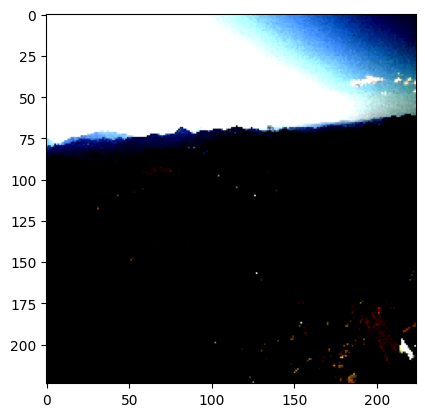

In [32]:
visualize(valid_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1])


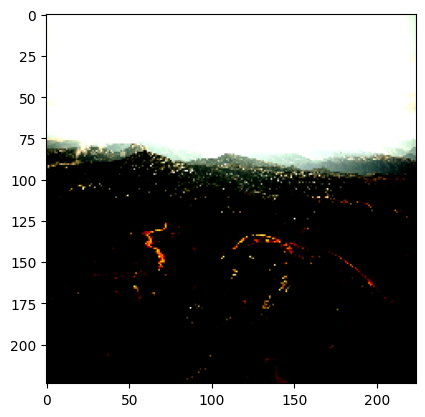

In [36]:
visualize(virtual_loader)